##### Author contributions
Please fill out for each of the following parts who contributed to what:
- Conceived ideas: everyone
- Performed math exercises: everyone
- Performed programming exercises: everyone
- Contributed to the overall final assignment: everyone

# Chapter 7
## Recurrent neural networks


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Brightspace before the deadline (see Brightspace).

Learning goals:
1. Get familiar with recurrent hidden units
1. Implement a simple RNN (Elman network) in PyTorch
1. Implement an LSTM-based neural network in PyTorch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# set seed for reproducibility
torch.manual_seed(43)
np.random.seed(43)

### Exercise 1  (1 point)

Consider a recurrent neural network with one input unit $x$, one sigmoid recurrent hidden unit $h$, and one linear output unit $y$. The values of $x$ are given for 3 time points in `x_t`. As this is a very small RNN, $W^i$, $W^h$ and $W^o$ are given as the scalar values `w_i`, `w_h` and `w_o` respectively. The hidden unit has an added bias `h_bias`. The hidden unit state is initialized with `0.0`. The only 'value-manipulating' activation function in this network is the sigmoid activation $\sigma(\cdot)$ on the hidden unit. 

1. Write down the forward pass of this network for a specific time point $t$. 
1. What is the value of the hidden state $h$ after processing the last input `x_t[2]`? 
1. What is the output `y` of the network after processing the last input `x_t[2]`? 

\begin{eqnarray*}
h_t &=& \\ 
y_t &=&  \\
\end{eqnarray*}


For 1.2 and 1.3, you can either compute the solution by hand (show clearly how you arrived there, 3 decimal points) or write code to find the answer. 

In [2]:
# inputs over times 0, 1, 2:
x_t = [9.0, 4.0, -2.0]

# weights and bias terms: 
w_i = 0.5
w_h = -1.0
w_o = -0.7
h_bias = -1.0
y_bias = 0.0

### Solution 1:

1. The forward pass for the network is 
\begin{eqnarray*}
h_t &=& \sigma(w\_i \cdot x_t + w\_h \cdot h_{t-1} + h_b)\\ 
y_t &=&  w\_o \cdot h_t + y_b\\
\end{eqnarray*}
where $h_b$ and $y_b$ are the biases. 
For $t=0$, we have
$$h_0 = \sigma(w\_i \cdot x_0 + h_b)$$

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

h = 0.0
for x in x_t:
    h = sigmoid(w_i * x + w_h * h + h_bias)
    y = w_o * h + y_bias

print("h: ", h)
print("y: ", y)

h:  0.07534608655539546
y:  -0.05274226058877682


### Code introduction

We will apply two recurrent neural networks to learn a dynamic variant of the *adding problem*. First, run the next cell and inspect the output. 

There is a stream of inputs to the network, two at each time step. The first input unit will receive a series of decimal numbers in the interval $[-1,1]$. The second input unit will receive the numbers $0$, $-1$, or $1$. The target is the sum of the preceding two decimal numbers that came together with the number $1$ (called the marker, `x` in the generated output), and it should be produced whenever a marker has been seen. In the beginning until two of these markers have been seen, the output will stay 0. 


Below you will find two functions: 
1. `create_addition_data`: Generates sequential training data sets `X` and `T` for the dynamic *adding problem*, returns numpy array.
1. `MyDataset`: a custom PyTorch dataset that makes sure dimensions are as PyTorch likes them, and can return individual samples the way PyTorch wants them.

Note, the data are represented in a dictionary called `data`. To access the training, validation, and testing data, you can call `data["train"]`, `data["valid]`, and `data["test"]` respectively.

In [4]:
def create_addition_data(n_samples=3000):
    # This is a dynamic variant of the adding problem. 
    
    # Random numbers in [-1.0,1.0]): 
    X1 = np.random.uniform(low=-1.0, high=1.0, size=(n_samples,) )   
    
    # Random markers [-1.0, 0.0, 1.0] (1.0 marks the numbers that should be added):
    X2 = np.random.choice([-1.0, 0.0, 1.0], size=(n_samples,), p=[0.25, 0.25, 0.5])
    
    # Combine
    X = np.vstack((X1, X2)).T.astype("float32")

    # Create targets
    T = np.zeros((n_samples, 1)).astype("float32")

    # Get indices of 1.0
    markers = np.nonzero(X2 == 1.0)[0]
    
    # Generate data
    mem = X1[markers[0]]
    for mi, marker in enumerate(markers[1:]):
        T[marker] = mem + X1[marker]
        mem = X1[marker]
                
    return X, T

In [5]:
# Long as the markers x are sparse
X, T = create_addition_data(n_samples=100)

# Print some data
print("Data for the adding problem (x marks 1.0):")
for t in range(X.shape[0]):
    print("Time: {:03d} \t x: ({:+.3f} , {}) \t t: {:+.3f} ".format(
        t, X[t,0], 'x' if X[t,1] == 1.0 else ' ', T[t,0]))

Data for the adding problem (x marks 1.0):
Time: 000 	 x: (-0.770 ,  ) 	 t: +0.000 
Time: 001 	 x: (+0.218 ,  ) 	 t: +0.000 
Time: 002 	 x: (-0.733 ,  ) 	 t: +0.000 
Time: 003 	 x: (-0.519 ,  ) 	 t: +0.000 
Time: 004 	 x: (-0.346 , x) 	 t: +0.000 
Time: 005 	 x: (+0.718 , x) 	 t: +0.373 
Time: 006 	 x: (+0.332 , x) 	 t: +1.050 
Time: 007 	 x: (+0.082 , x) 	 t: +0.415 
Time: 008 	 x: (-0.942 ,  ) 	 t: +0.000 
Time: 009 	 x: (+0.467 , x) 	 t: +0.550 
Time: 010 	 x: (-0.210 , x) 	 t: +0.257 
Time: 011 	 x: (+0.604 , x) 	 t: +0.394 
Time: 012 	 x: (-0.491 , x) 	 t: +0.113 
Time: 013 	 x: (-0.886 , x) 	 t: -1.377 
Time: 014 	 x: (+0.733 ,  ) 	 t: +0.000 
Time: 015 	 x: (-0.558 , x) 	 t: -1.444 
Time: 016 	 x: (-0.190 ,  ) 	 t: +0.000 
Time: 017 	 x: (-0.368 , x) 	 t: -0.926 
Time: 018 	 x: (-0.847 ,  ) 	 t: +0.000 
Time: 019 	 x: (+0.686 ,  ) 	 t: +0.000 
Time: 020 	 x: (+0.698 , x) 	 t: +0.330 
Time: 021 	 x: (+0.943 ,  ) 	 t: +0.000 
Time: 022 	 x: (-0.229 , x) 	 t: +0.469 
Time: 023 	 x:

In [6]:
# Make PyTorch dataset
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, T):
        self.X = torch.from_numpy(X).type(torch.FloatTensor) # [n_examples, n_samples, n_features]
        self.T = torch.from_numpy(T).type(torch.FloatTensor) # [n_examples, n_samples]
        
    def __getitem__(self, index):
        return self.X[index, :, :], self.T[index]
    
    def __len__(self):
        return self.X.size()[0]

In [7]:
n_examples = 9
n_samples = 3000
data = {}

# Define training data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["train"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=3)

# Define validation data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["valid"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=3)

# Define test data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["test"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=1)

### Exercise 2: training a network  (0.5 points)

We need a function to train a `model`. This function `train_model(model, data, optimizer, criterion, n_epochs)` should do the following: 

1. Loop `n_epochs` times over the dataset, and loop over minibatches
1. Train the model on the training data and save the loss per epoch
1. Validate the model on the validation data and save the loss per epoch
1. The function should return the trained model and the losses

Note: this function is quite similar again as the function your wrote wor the MLP and CNN. The only difference is that we do not need to compute an accuracy, as we are performing regression here.

### Solution 2

In [8]:
def train_model(model, data, optimizer, criterion, n_epochs):
    """
    @description:
        function to train a PyTorch Model
    @arguments:
        model (torch) - model to be trained
        data (torch) - dataset loader
        optimizer (torch) - optimization function
        criterion (torch) - loss function
        n_epochs (int) - number of training epochs (default = 200)
        transform (torch) - input transformation
    @returns:
        model (torch) - trained model
        train_loss (np array) - training loss over epochs
        valid_loss (np array) - validation loss over epochs
    """
    train_loss = np.zeros(n_epochs) # buffer for training loss over epochs
    valid_loss = np.zeros(n_epochs) # buffer for validation loss over epochs

    for epoch in range (n_epochs):
        
        # set model in training mode
        model.train()
        for images, labels in data["train"]:
            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward function
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, labels)
            # save loss
            train_loss[epoch] = loss
            # backpropagation function
            loss.backward()
            # optimize
            optimizer.step()
        
        # set model in training mode
        model.eval()
        for images, labels in data["valid"]:
            # forward function
            with torch.no_grad():
                outputs = model(images)
            # compute loss
            valid_loss[epoch] = criterion(outputs, labels)
        
        # print training log
        print("epoch {}: train_loss: {:.3f} | val_loss: {:.3f}".format(epoch+1,train_loss[epoch],valid_loss[epoch]))

    return model, train_loss, valid_loss  

### Exercise 3: Testing a network  (1.5 points)

We neede a function to test a trained `model`. This function `test_model(model, data)` should do the following: 

1. Let `model` predict outputs on the testing data. For this, iterate through test data `data["test]` and pass each sample through `model`. 
1. Save the model output as well as the target output
1. The function should return the predicted and target outputs

### Solution 3

In [36]:
def test_model(model, data):
    """
    @description:
        function to test a PyTorch Model
    @arguments:
        model (torch) - model to be trained
        data (torch) - dataset loader
    @returns:
        y_pred (np array) - predicted outputs
        y_true (np array) - true outputs
    """
    y_pred = []
    y_true = []
    
    # set model in training mode
    model.eval()
    for images, labels in data["test"]:
        # forward function
        with torch.no_grad():
            outputs = model(images)
        
        # reshape tensors to 1D and convert into arrays
        outputs = outputs.view(1,-1).T.numpy()[:,0]
        labels = labels.view(1,-1).T.numpy()[:,0]
        
        # add new values to arrays
        y_pred.append(outputs.tolist()) 
        y_true.append(labels.tolist()) 
        
    return y_pred, y_true

### Exercise 4: Simple RNN  (3 points)

We first implement a simple recurrent architecture (a simple [Elman network](http://mnemstudio.org/neural-networks-elman.htm)). 

1. First implement the linear layers `l1` and `l2`. They should lead from `n_input` input units over `n_hidden` hidden units to `n_out` output units.
1. Add a recurrent linear weight layer `hr`. These are weights that self-connect to the hidden units. The input will be the values of the `n_hidden` hidden units, and they should project back to the `n_hidden` hidden units. 
1. A forward pass will update the hidden state with the inputs and the recurrent layer weights, and produce the output from the hidden unit. Specifically you should do the following: 
    2. If we are at the first time point, the hidden state should be set to the input passed through `l1` and `tanh` activations.
    2. If the hidden state has information from previous time points: a) Pass the input through `l1`. b) Pass the hidden state through the recurrent weight layer `hr`. c) The sum of a) and b) should be passed through the `tanh` activation. d) The result should be the new hidden state (used for the next time point).
    2. Finally pass the hidden state through layer `l2`. This produces the output `y` for that time point.
1. The forward pass will receive data `x` with shape [batch_size, time_points, features]. So within the forward pass, you will have to loop over time points, performing the steps as descibed above. The output of the forward pass is then output `y` with shape [batch_size, time_points, 1].

Note: this exercise could also be done with nn.RNN(). However, we want you to understand what a RNN is doing, so we want you to use nn.Linear instead.

### Solution 4

In [10]:
class RNN(nn.Module):
    """
    PyTorch Implementation of Simple RNN
    """
    def __init__(self, n_input, n_hidden, n_out):
        """
        @description:
            Initial Network Setup
        @arguments:
            n_input (int) - Input Size
            n_hidden (int) - number of hidden units
            n_out (int) - Output Size
        """
        super(RNN, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_out)
        self.hr = nn.Linear(n_hidden, n_hidden)


    def forward(self, x):
        """
        @description:
            Feed-forward function
        @arguments:
            x (tensor) - input tensor
        @returns:
            y (tensor) - output tensor
        """
        y = torch.zeros([x.shape[0], x.shape[1], 1])
        for i in range(0, x.shape[1]):
            if i == 0:
                self.h = torch.tanh(self.l1(x[:, i, :]))
            else:
                l = self.l1(x[:, i, :])
                j = self.hr(self.h)
                self.h = torch.tanh(l+j)
            y[:, i, :] = self.l2(self.h)
        return y        

### Exercise 5: Setup and run (1 point)

Try your simple `RNN` with the dynamic addition task. 

1. Define the model. `RNN` should have **2 hidden units**.
1. Define the loss as the Mean Squared Error loss, and use an Adam optimizer.
1. Train your model for several epochs on the data with `train_model`.
1. Plot the train and validation losses. 
1. Test the trained model with `test_model` 
1. Plot at least one target time series together with the predicted time series

Based on the losses and predictions, what would your conclusion be? Did the simple RNN learn the task? 

### Solution 5

In [11]:
import timeit

In [12]:
# define training parameters
N_EPOCHS = 50
N_INPUT = 2
N_HIDDEN = 2
N_OUTPUT = 1

In [13]:
# define model
rnn = RNN(N_INPUT, N_HIDDEN, N_OUTPUT)
# define criterion (loss function)
criterion = nn.MSELoss()
# define optimizer
optimizer = optim.Adam(rnn.parameters())

In [14]:
# start timer for training model
start = timeit.default_timer()
# train model
rnn, train_loss, valid_loss = train_model(rnn, data, optimizer, criterion, N_EPOCHS)
# stop timer
stop = timeit.default_timer()
print('Total Training Time: ', stop - start)  

epoch 1: train_loss: 0.645 | val_loss: 0.628
epoch 2: train_loss: 0.635 | val_loss: 0.618
epoch 3: train_loss: 0.625 | val_loss: 0.609
epoch 4: train_loss: 0.616 | val_loss: 0.599
epoch 5: train_loss: 0.606 | val_loss: 0.590
epoch 6: train_loss: 0.597 | val_loss: 0.582
epoch 7: train_loss: 0.589 | val_loss: 0.573
epoch 8: train_loss: 0.581 | val_loss: 0.565
epoch 9: train_loss: 0.573 | val_loss: 0.557
epoch 10: train_loss: 0.565 | val_loss: 0.550
epoch 11: train_loss: 0.557 | val_loss: 0.542
epoch 12: train_loss: 0.550 | val_loss: 0.535
epoch 13: train_loss: 0.543 | val_loss: 0.529
epoch 14: train_loss: 0.536 | val_loss: 0.522
epoch 15: train_loss: 0.530 | val_loss: 0.516
epoch 16: train_loss: 0.524 | val_loss: 0.510
epoch 17: train_loss: 0.518 | val_loss: 0.504
epoch 18: train_loss: 0.512 | val_loss: 0.499
epoch 19: train_loss: 0.507 | val_loss: 0.493
epoch 20: train_loss: 0.502 | val_loss: 0.488
epoch 21: train_loss: 0.497 | val_loss: 0.483
epoch 22: train_loss: 0.492 | val_loss: 0.4

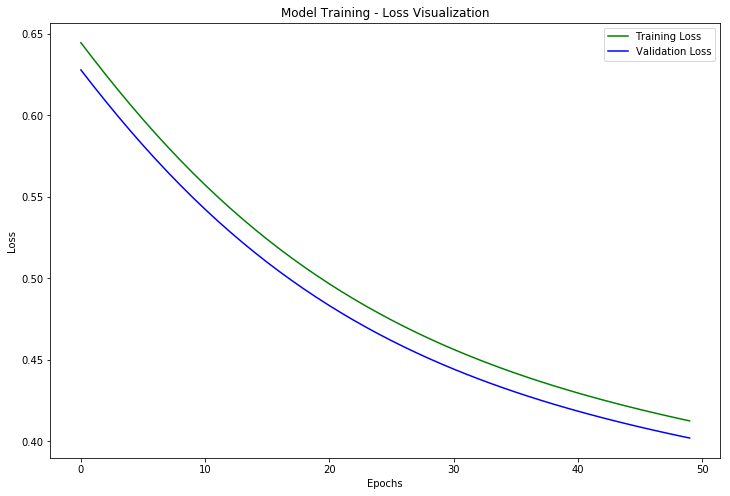

In [15]:
# plot losses
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_loss, 'g-', label='Training Loss')
plt.plot(np.arange(0, N_EPOCHS), valid_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Loss Visualization')
plt.legend(loc='best')
plt.show()

In [28]:
# test model
y_pred, y_true = test_model(rnn, data)

9


3000
3000


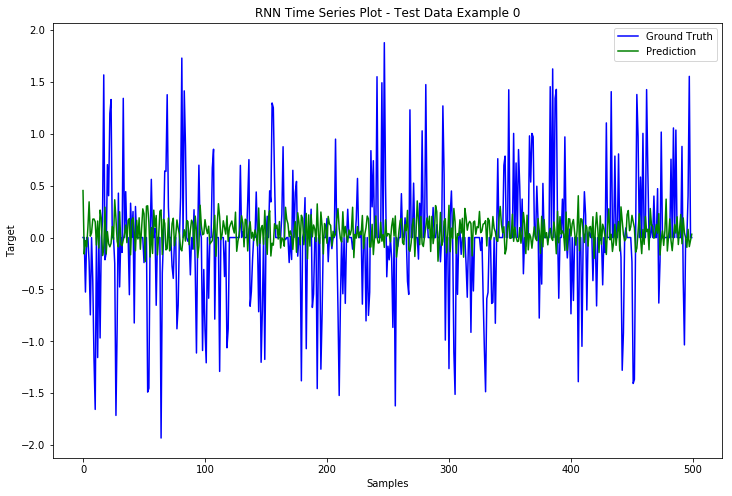

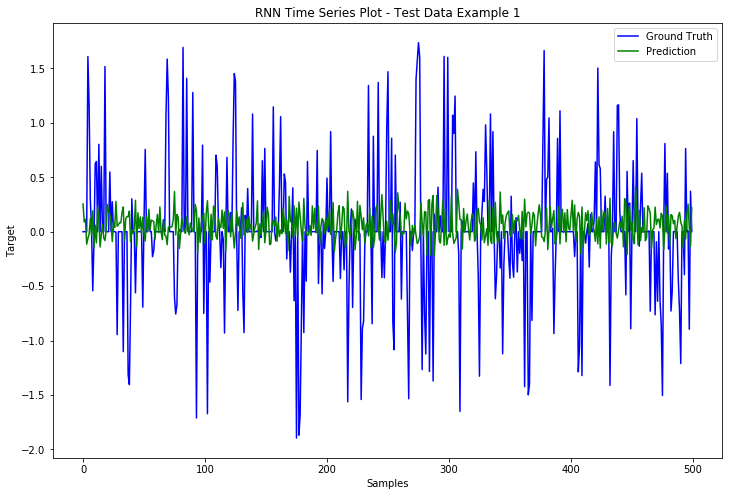

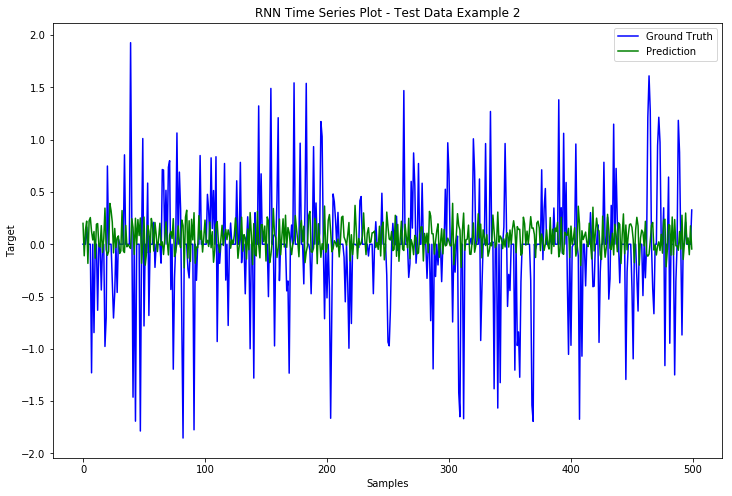

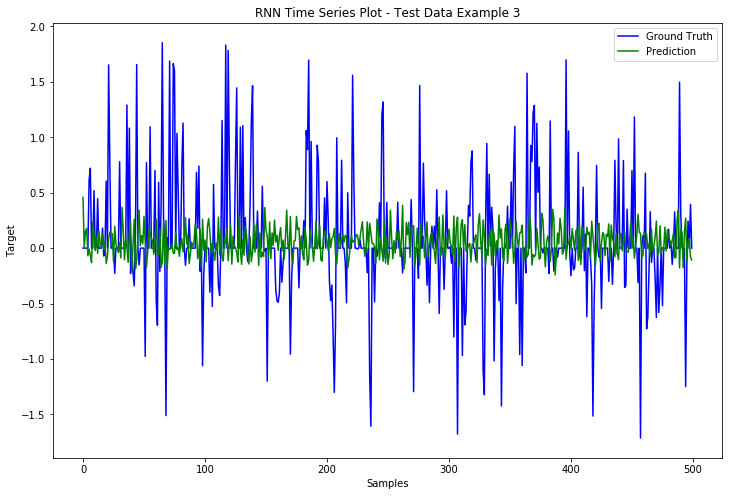

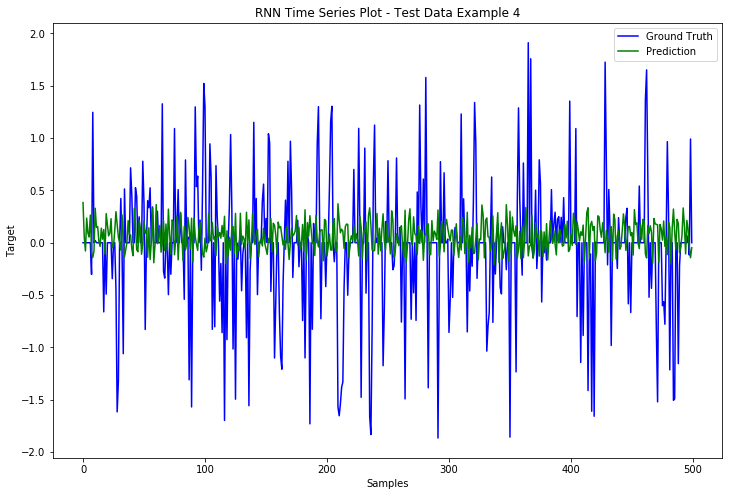

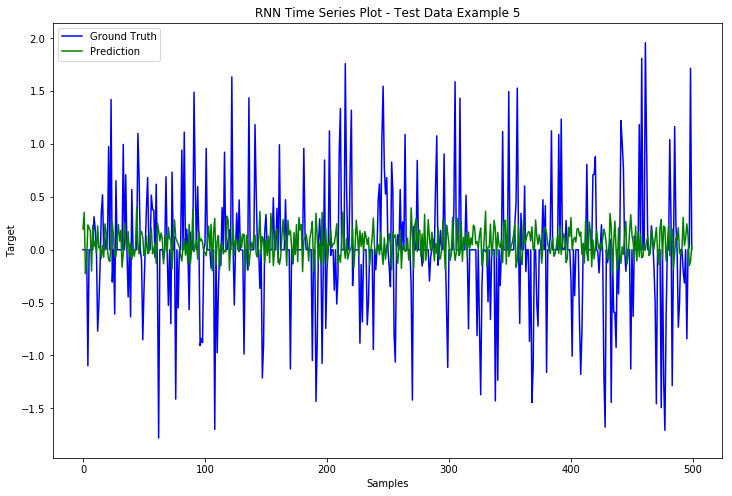

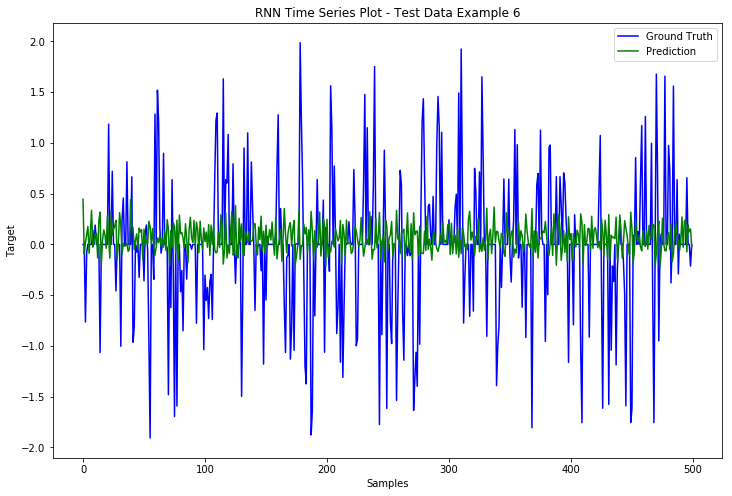

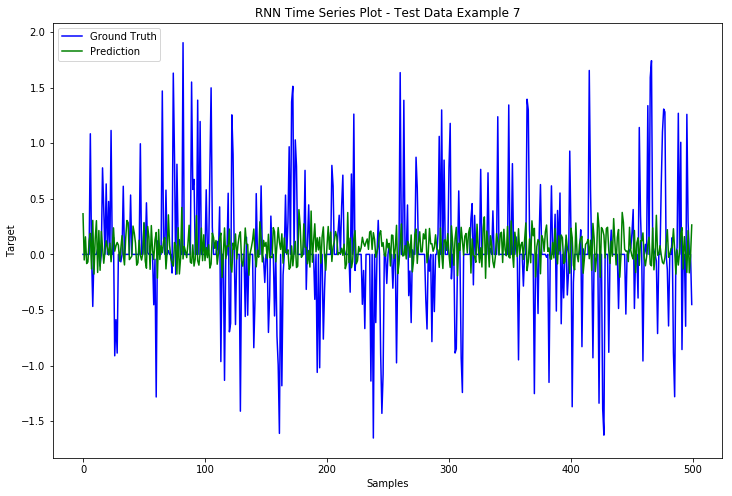

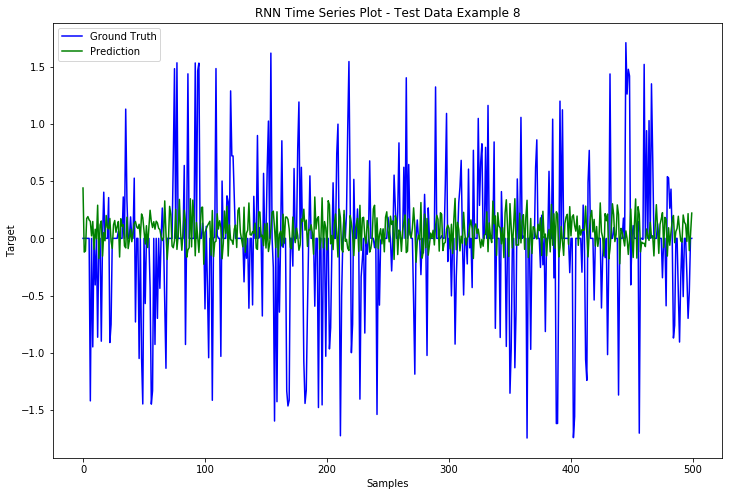

In [29]:
print(len(y_pred[0]))
print(len(y_true[0]))
# plot time series
for i in range(n_examples):
    plt.figure(figsize=(12,8))
    # data clip to view the plot clearly
    plt.plot(np.arange(0, len(y_true[i][0:500])), y_true[i][0:500], 'b-', label='Ground Truth')
    plt.plot(np.arange(0, len(y_pred[i][0:500])), y_pred[i][0:500], 'g-', label='Prediction')
    plt.xlabel('Samples')
    plt.ylabel('Target')
    plt.title('RNN Time Series Plot - Test Data Example {}'.format(i))
    plt.legend(loc='best')
    plt.show()

**Answer**: In this small amount of epochs (50), it looks like the RNN did not really learn the pattern. We would have like to run it for more epochs, but the running time was already quite long (4

### Exercise 6: LSTM RNN (2 points)

Long-Short Term Memory (LSTM) units have more [powerful functionality](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), such as selective forgetting, and they are able to keep track of long-term dependencies. This might be useful for the adding task. 

Implement the `LSTM` model:

1. `lstm` should be an `LSTM` layer leading from the `n_input` inputs to the `n_hidden` hidden units.
1. `fc` should be a fully-connected (linear) layer leading from the hidden units (output of `lstm`) to the `n_out` output units. 
1. The network does not make use of further activation functions. 

### Solution 6

In [18]:
class LSTM(nn.Module):
    """
    PyTorch Implementation of LSTM RNN
    """
    def __init__(self, n_input, n_hidden, n_out):
        """
        @description:
            Initial Network Setup
        @arguments:
            n_input (int) - Input Size
            n_hidden (int) - number of hidden units
            n_out (int) - Output Size
        """
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden)
        self.fc = nn.Linear(n_hidden, n_out)
    
    def forward(self, x):
        """
        @description:
            Feed-forward function
        @arguments:
            x (tensor) - input tensor
        @returns:
            y (tensor) - output tensor
        """
        lstm_out, self.hidden = self.lstm(x)
        y = self.fc(lstm_out)
        return y       

### Exercise 7: Setup and run (1 point)

Try your `LSTM` model with the dynamic addition task. 

1. Define the model. `LSTM` should have **2 hidden units**.
1. Define the loss as the Mean Squared Error loss, and use an Adam optimizer.
1. Train your model for several epochs on the data with `train_model`.
1. Plot the train and validation losses. 
1. Test the trained model with `test_model` 
1. Plot at least one target time series together with the predicted time series

Did the LSTM network capture the task better? Did any of the two capture the task perfectly? Or are the two networks on par? 

### Solution 7

In [43]:
# define training parameters
N_EPOCHS = 50
N_INPUT = 2
N_HIDDEN = 2
N_OUTPUT = 1

In [44]:
# define model
lstm = LSTM(N_INPUT, N_HIDDEN, N_OUTPUT)
# define optimizer
optimizer = optim.Adam(lstm.parameters())
# define criterion (loss function)
criterion = nn.MSELoss()

In [45]:
# start timer for training model
start = timeit.default_timer()
# train model
lstm, train_loss, valid_loss = train_model(lstm, data, optimizer, criterion, N_EPOCHS)
# stop timer
stop = timeit.default_timer()
print('Total Training Time: ', stop - start)  

epoch 1: train_loss: 0.353 | val_loss: 0.343
epoch 2: train_loss: 0.352 | val_loss: 0.342
epoch 3: train_loss: 0.351 | val_loss: 0.341
epoch 4: train_loss: 0.351 | val_loss: 0.341
epoch 5: train_loss: 0.350 | val_loss: 0.340
epoch 6: train_loss: 0.349 | val_loss: 0.340
epoch 7: train_loss: 0.349 | val_loss: 0.339
epoch 8: train_loss: 0.348 | val_loss: 0.339
epoch 9: train_loss: 0.348 | val_loss: 0.338
epoch 10: train_loss: 0.347 | val_loss: 0.338
epoch 11: train_loss: 0.347 | val_loss: 0.337
epoch 12: train_loss: 0.347 | val_loss: 0.337
epoch 13: train_loss: 0.346 | val_loss: 0.336
epoch 14: train_loss: 0.346 | val_loss: 0.336
epoch 15: train_loss: 0.345 | val_loss: 0.335
epoch 16: train_loss: 0.345 | val_loss: 0.335
epoch 17: train_loss: 0.344 | val_loss: 0.335
epoch 18: train_loss: 0.344 | val_loss: 0.334
epoch 19: train_loss: 0.344 | val_loss: 0.334
epoch 20: train_loss: 0.343 | val_loss: 0.334
epoch 21: train_loss: 0.343 | val_loss: 0.333
epoch 22: train_loss: 0.343 | val_loss: 0.3

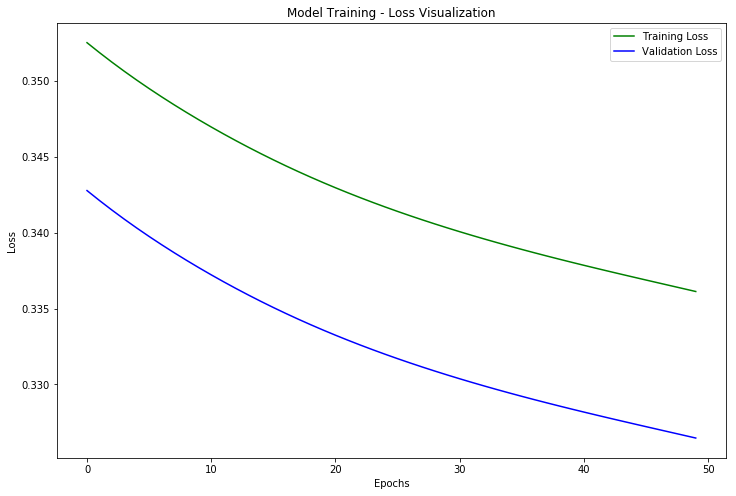

In [46]:
# plot losses
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_loss, 'g-', label='Training Loss')
plt.plot(np.arange(0, N_EPOCHS), valid_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Loss Visualization')
plt.legend(loc='best')
plt.show()

In [47]:
# test model
y_pred, y_true = test_model(lstm, data)

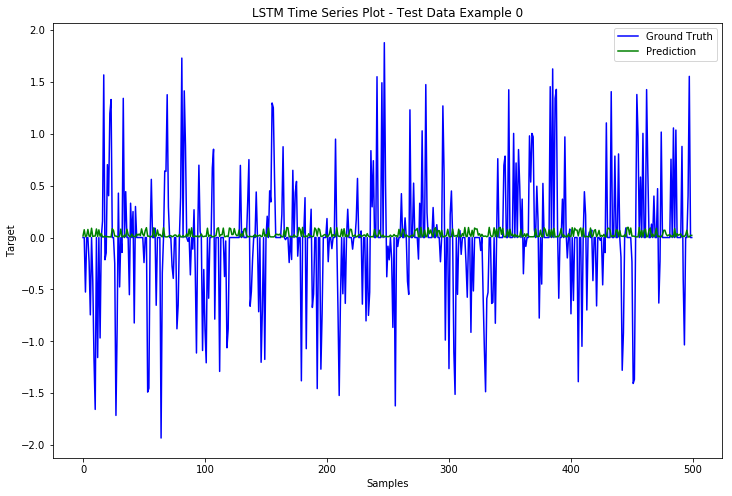

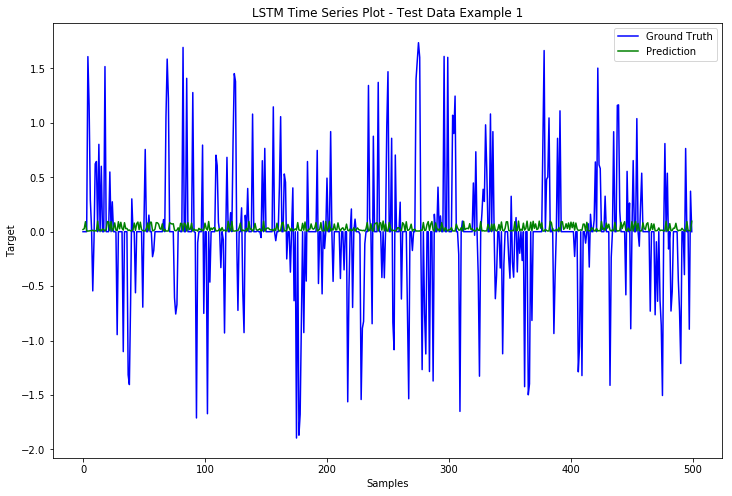

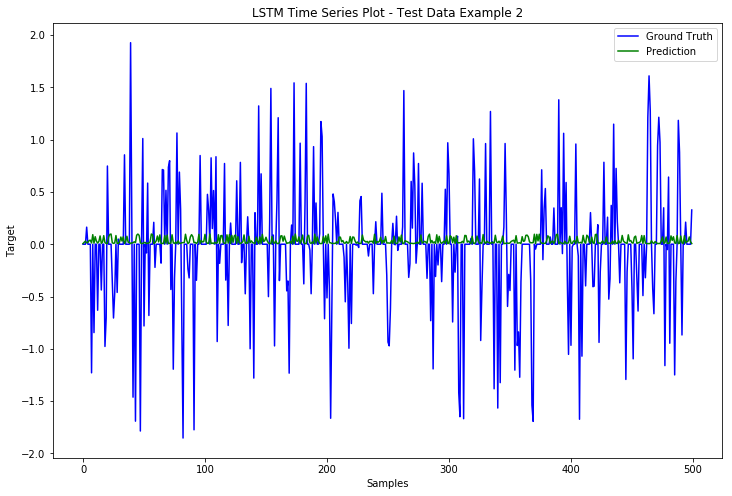

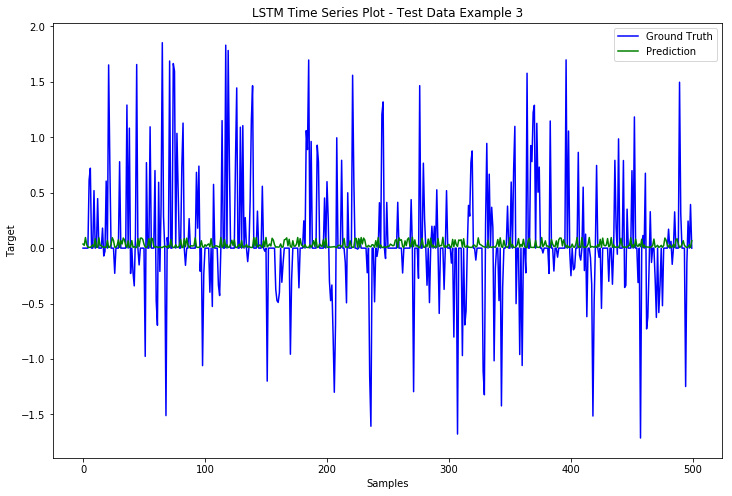

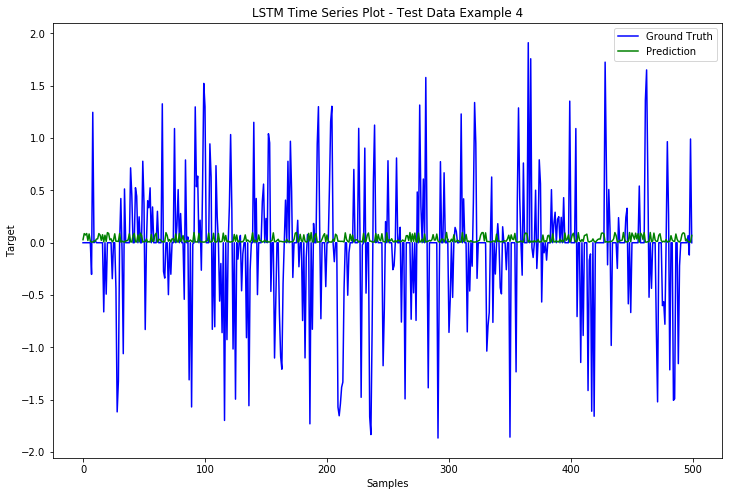

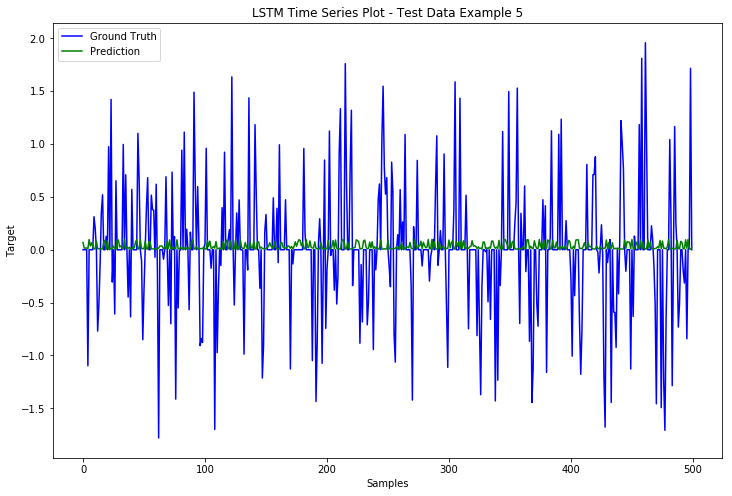

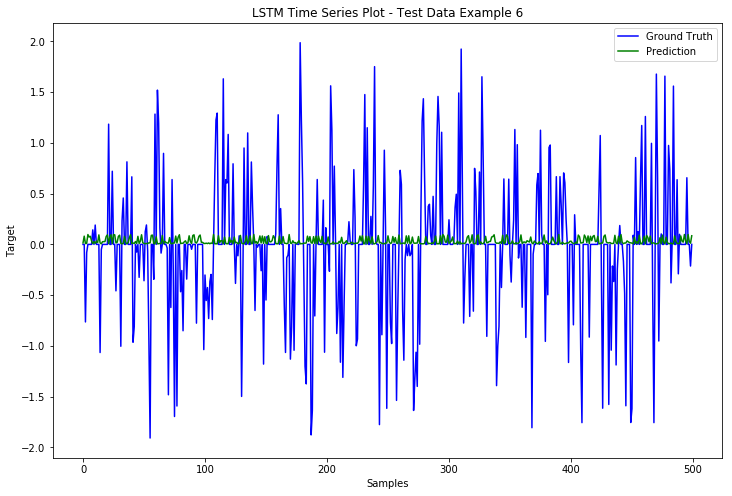

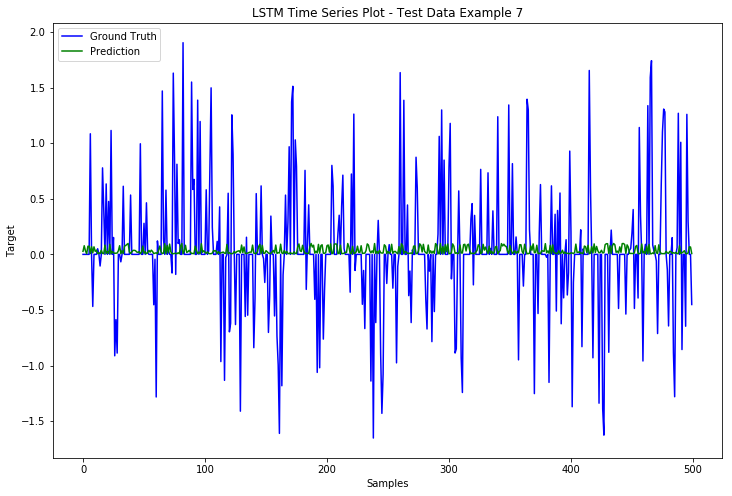

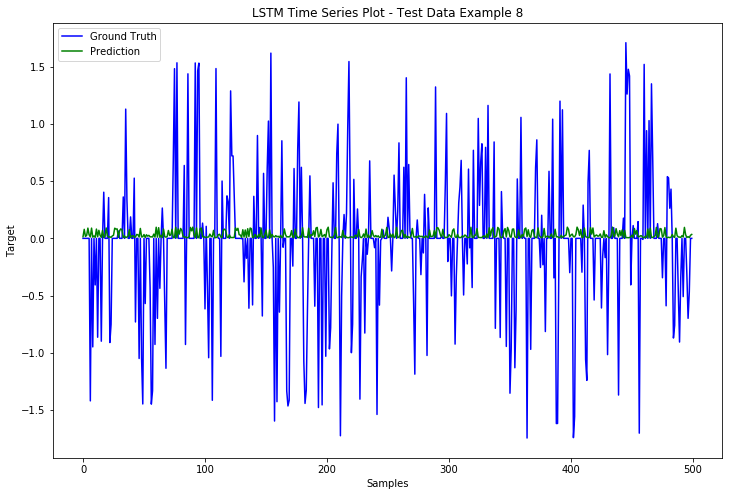

In [48]:
# plot time series
for i in range(n_examples):
    plt.figure(figsize=(12,8))
    # data clip to view the plot clearly
    plt.plot(np.arange(0, len(y_true[i][0:500])), y_true[i][0:500], 'b-', label='Ground Truth')
    plt.plot(np.arange(0, len(y_pred[i][0:500])), y_pred[i][0:500], 'g-', label='Prediction')
    plt.xlabel('Samples')
    plt.ylabel('Target')
    plt.title('LSTM Time Series Plot - Test Data Example {}'.format(i))
    plt.legend(loc='best')
    plt.show()

**Answer**: The LSTM is much faster than the RNN. However, in score, we do not really see a difference. LSTM: 0.326, RNN: 0.402, for 50 epochs, but this differs quite a bit from run to run. It seems like both systems have trouble learning the dependency in the small amount of epochs when looking at the time series plot. When we do 400 epochs for the LSTM, it looks like it finally starts to learn the pattern some more. Sadly, running the RNN took so long we could not really run it for 400 epochs as well, so that makes it harder to compare the two.